In [22]:
from data import Dataset
from sc_ged import SC_GED
from sc_sum import SC_SUM
from sc_al import SC_AL
from k_kmeans import K_KMEANS
from utils import modularity

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import time

%reload_ext autoreload
%autoreload 2

In [92]:
def evaluation_pipeline(dataset, model):
    model.fit()
    purity, nmi, ri = model.evaluate(dataset.labels, verbose=False)
    return purity, nmi, ri

dataset_names = ["Cora", "AUCS", "MIT"]
datasets = [Dataset(name) for name in dataset_names]
model_names = ["SC_GED", "SC_SUM", "SC_AL", "K_KMEANS"]
metric_names = ["purity", "nmi", "ri", "time"]

# dataframe with dataset as rows,  and the columns are the different models for each model three columns for purity, nmi, ri
results = pd.DataFrame(columns=pd.MultiIndex.from_product([model_names, metric_names]), index=dataset_names)

results


SC_GED                SC_SUM                 SC_AL                 \
     purity  nmi   ri time purity  nmi   ri time purity  nmi   ri time   
Cora    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN   
AUCS    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN   
MIT     NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN   

     K_KMEANS                 
       purity  nmi   ri time  
Cora      NaN  NaN  NaN  NaN  
AUCS      NaN  NaN  NaN  NaN  
MIT       NaN  NaN  NaN  NaN

In [43]:
most_informative_layer = {
    "Cora": 1,
    "AUCS": 0,
    "MIT": 2
}

for dataset, dataset_name in zip(datasets, dataset_names):
    for model_name in model_names:
        k = np.unique(dataset.labels).shape[0]
        if model_name == "SC_GED":
            most_informative = most_informative_layer[dataset_name]
            model = SC_GED(dataset.MLG, k, most_informative=most_informative, alpha=0.5, beta=10)
        elif model_name == "SC_SUM":
            model = SC_SUM(dataset.MLG, k)
        elif model_name == "SC_AL":
            model = SC_AL(dataset.MLG, k)

        start_time = time.time()
        purity, nmi, ri = evaluation_pipeline(dataset, model)
        end_time = time.time()
        elapsed_time = end_time - start_time

        results.loc[dataset_name, (model_name, "purity")] = purity
        results.loc[dataset_name, (model_name, "nmi")] = nmi
        results.loc[dataset_name, (model_name, "ri")] = ri
        results.loc[dataset_name, (model_name, "time")] = elapsed_time
# results.to_csv("cora1aucs0mit2.csv")

Joint Eigen Decomposition: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


In [98]:
results = pd.read_csv("cora1aucs0mit2.csv", index_col=0, header=[0, 1])
results

SC_GED                                    SC_SUM                      \
        purity       nmi        ri        time    purity       nmi        ri   
Cora  0.560488  0.122499  0.566916  117.223338  0.522752  0.009180  0.396066   
AUCS  0.888889  0.880226  0.950384    2.317212  0.833333  0.856933  0.924528   
MIT   0.577778  0.313153  0.653433    6.102214  0.477778  0.221917  0.529838   

                   SC_AL                                K_KMEANS            \
          time    purity       nmi        ri      time      time    purity   
Cora  0.365990  0.526082  0.018007  0.395844  0.381999  0.821548  0.704772   
AUCS  0.226999  0.833333  0.856933  0.924528  0.206000  0.051000  0.944444   
MIT   0.258381  0.477778  0.219710  0.528839  0.247000  0.050509  0.588889   

                          
           nmi        ri  
Cora  0.426607  0.639529  
AUCS  0.907945  0.965758  
MIT   0.302054  0.571036

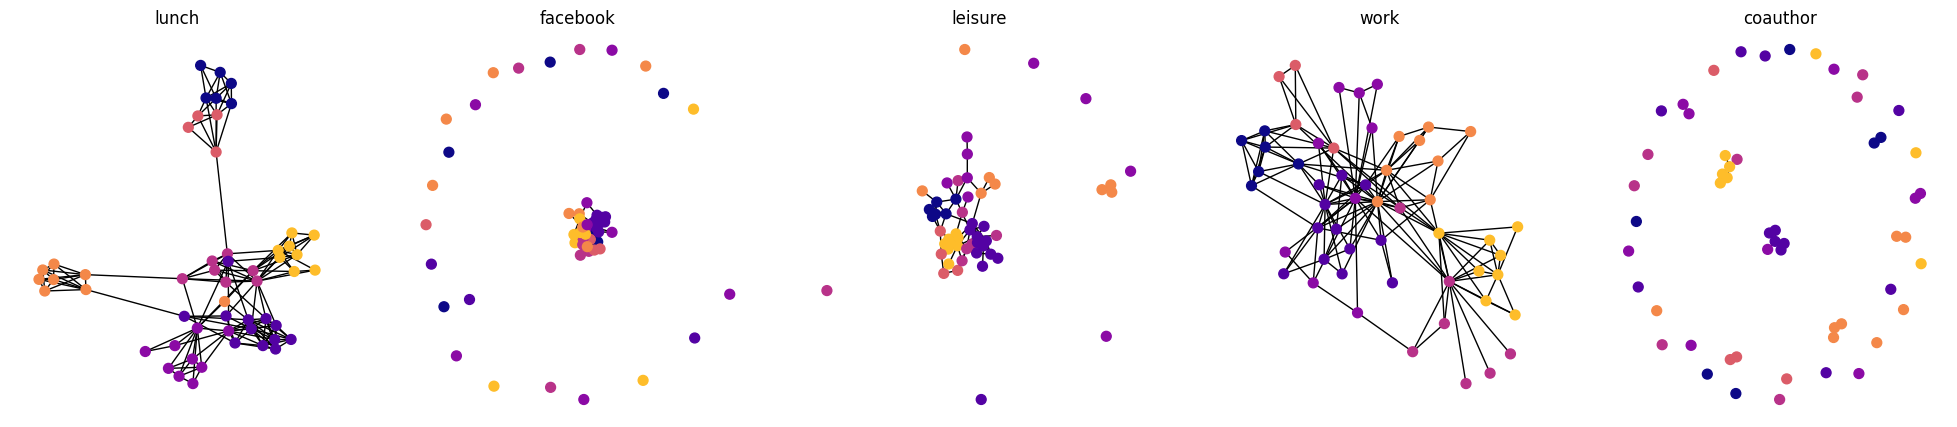

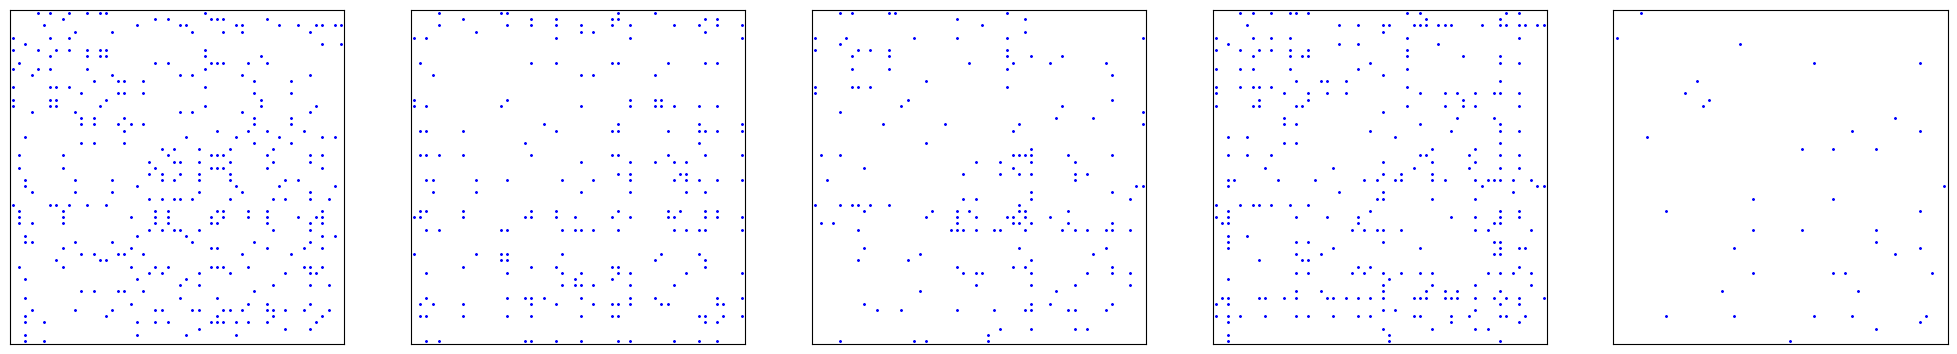

In [12]:
dataset = Dataset("AUCS", preprocess=False)
dataset.display(markersize=1)

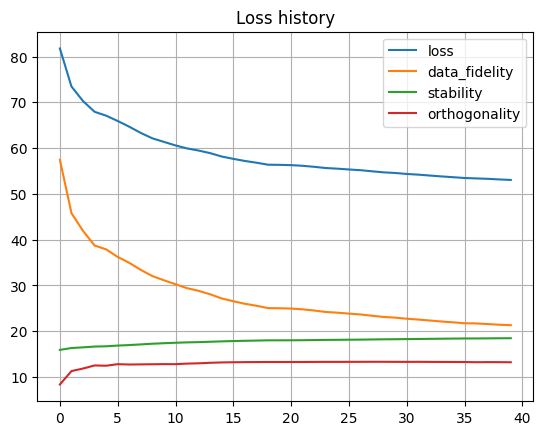

In [102]:
model.plot_loss()

In [100]:
k = np.unique(datasets[1].labels).shape[0]
model = SC_GED(datasets[1].MLG, k, most_informative=0, alpha=0.5, beta=10)
model.fit()
clustering = model.clustering
for layer, G in zip(datasets[1].layer_labels, datasets[1].MLG):
    m = modularity(G, clustering)
    print(f"Modularity of layer based on clustering {layer}: {m:.4f}")

Joint Eigen Decomposition: 100%|██████████| 40/40 [00:02<00:00, 19.21it/s]


Modularity of layer based on clustering lunch: 0.5997
Modularity of layer based on clustering facebook: 0.2721
Modularity of layer based on clustering leisure: 0.4740
Modularity of layer based on clustering work: 0.4000
Modularity of layer based on clustering coauthor: 0.6621


In [103]:
k = np.unique(datasets[1].labels).shape[0]
model = K_KMEANS(datasets[1].MLG, k)
model.fit()
clustering = model.clustering
for layer, G in zip(datasets[1].layer_labels, datasets[1].MLG):
    m = modularity(G, clustering)
    print(f"Modularity of layer based on clustering {layer}: {m:.4f}")

Modularity of layer based on clustering lunch: 0.5788
Modularity of layer based on clustering facebook: 0.2501
Modularity of layer based on clustering leisure: 0.4742
Modularity of layer based on clustering work: 0.3993
Modularity of layer based on clustering coauthor: 0.7109


Results:
* requires manually choosing beta and alpha for each specific case which is not always ideal when we don't have the real labels: very sensitive to alpha and beta values
* Requires a lot of comupations to find the eigenvalues of all layers and eigenvectors of the most informative layer: not suited for high dimentional datasets
* Modularity is high for coauthor layer as we put it as the most informative but also because members of the same group would more likely co-author together. Then there's the lunch and leisure which makes sense because if you work together you will more likely have outside activities together or eat together at lunch. The work was expected to be higher but maybe lunch groups can include different people from the group but not necessarily directly work together during working hours. Finally, the facebook has the lowest modularity as people from different working groups can be friends on social media with anyone from work. 
* A low alpha has no impact in this case on the stability of of P and Q. Maybe it's already inforced implicitly in the data fidelity term. Higher alpha values degrade the results.  

Ideas to implement:
* See how the data_fidelity, sparsity, orthogonality terms evolve over iterations (Normalize maybe and see the difference in scale to find the best beta and alpha)

* Evaluate the impact of different alpha and beta values to conclude the sensitivity of the model to hyperparams

* Implement more evaluation metrics like the ones in the paper

* Test this on a big graph dataset to conclude that it's not suitable for big datasets

* Show how the first eigen vectors can be mapped to 1D dimension 

* Maybe find more datasets with labels this time

